In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[4]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import (FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, 
                                             CONCRETE_MATERIAL, CS137_MATERIAL, CDTE_MATERIAL)
from src.utils.pre_processing.pre_processing import *
from src.utils.post_preocessing.post_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [19]:
materials = openmc.Materials([CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL])

In [20]:
# Surfaces
sphere = openmc.Sphere(r=10.0, surface_id=1)
detector = openmc.Sphere(x0=30., r=10.0, surface_id=2)
outer_boundary = openmc.Sphere(r=200.0, surface_id=3, boundary_type='vacuum')

# Create concrete wall using parallelepiped
wall_region = parallelepiped(-40, -20, -50, 50, -50, 50, surface_id_start=10) # type: ignore
wall_cell = openmc.Cell(name="concrete_wall", fill=CONCRETE_MATERIAL, region=wall_region)

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=3.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=10.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=11.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages

In [21]:
# Cells
source_cell = openmc.Cell(name="source_cell")
source_cell.fill = CS137_MATERIAL
source_cell.region = -sphere

detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = CDTE_MATERIAL
detector_cell.region = -detector

# Air cell (everything else inside the outer boundary, minus source, detector, and wall)
outer_boundary_cell = -outer_boundary
void_region = outer_boundary_cell & ~source_cell.region & ~detector_cell.region & ~wall_region
void_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=void_region)

universe = openmc.Universe(cells=[source_cell, detector_cell, wall_cell, void_cell])
geometry = openmc.Geometry(universe)

In [22]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

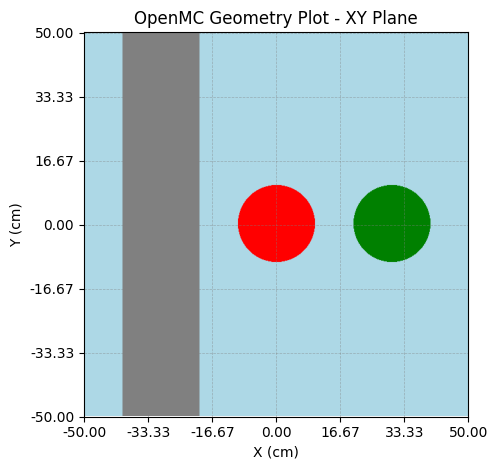

In [23]:
plot_geometry(materials=materials, width=100, height=100, saving_figure=False)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

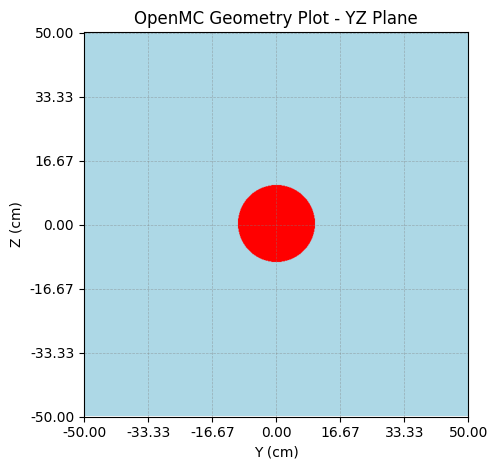

In [24]:
plot_geometry(materials=materials, width=100, height=100, plane="yz", saving_figure=False)

In [25]:
src = openmc.Source()
src.space = openmc.stats.Box(
    (-10, -10, -2.5), (10, 10, 2.5), only_fissionable=False)
src.angle = openmc.stats.Isotropic()
src.energy = openmc.stats.Discrete([661_700], [1.0])
src.particle = "photon"

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [26]:
radius = openmc.stats.Discrete([3], [1])
r = openmc.stats.Uniform(0.0, 0.999999*3.0)  # Use a float for the upper bound
phi = openmc.stats.Uniform(0, 2*np.pi)
theta = openmc.stats.Uniform(-1, 1)
source = openmc.IndependentSource()
source.space = openmc.stats.SphericalIndependent(r, phi, theta)
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([661_700], [1.0])
source.particle = "photon"

In [27]:
source = openmc.Source()
source.space = openmc.stats.spherical_uniform(r_inner=0, r_outer=10, origin=(0, 0, 0))  # Reference direction for isotropic sampling
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([661_700], [1.0])
source.particle = "photon"

In [28]:
tallies = openmc.Tallies([])
mesh_tally_xy = mesh_tally_plane(plane="xy", particule_type="photon", name_mesh_tally="flux_mesh_xy")
tallies.append(mesh_tally_xy)

mesh_tally_yz = mesh_tally_plane(plane="yz", particule_type="photon", name_mesh_tally="flux_mesh_yz")
tallies.append(mesh_tally_yz)

In [29]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 30
settings.batches = batches_number
settings.particles = 10**6
settings.source = source
# settings.uniform_source_sampling = True

settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [30]:
materials.export_to_xml()
geometry.export_to_xml()
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=6.
  warn(msg, IDWarning)


In [31]:
remove_previous_results(batches_number)
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [32]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

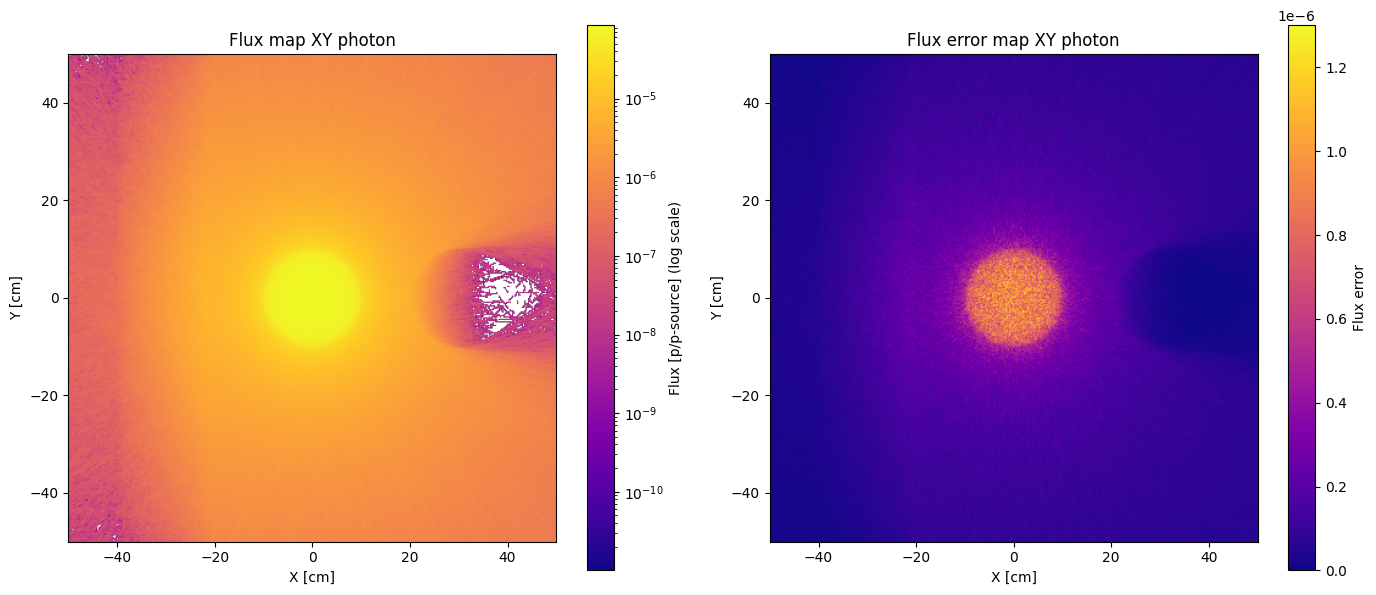

In [33]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_xy", particule_type="photon",
                plane = "xy", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)

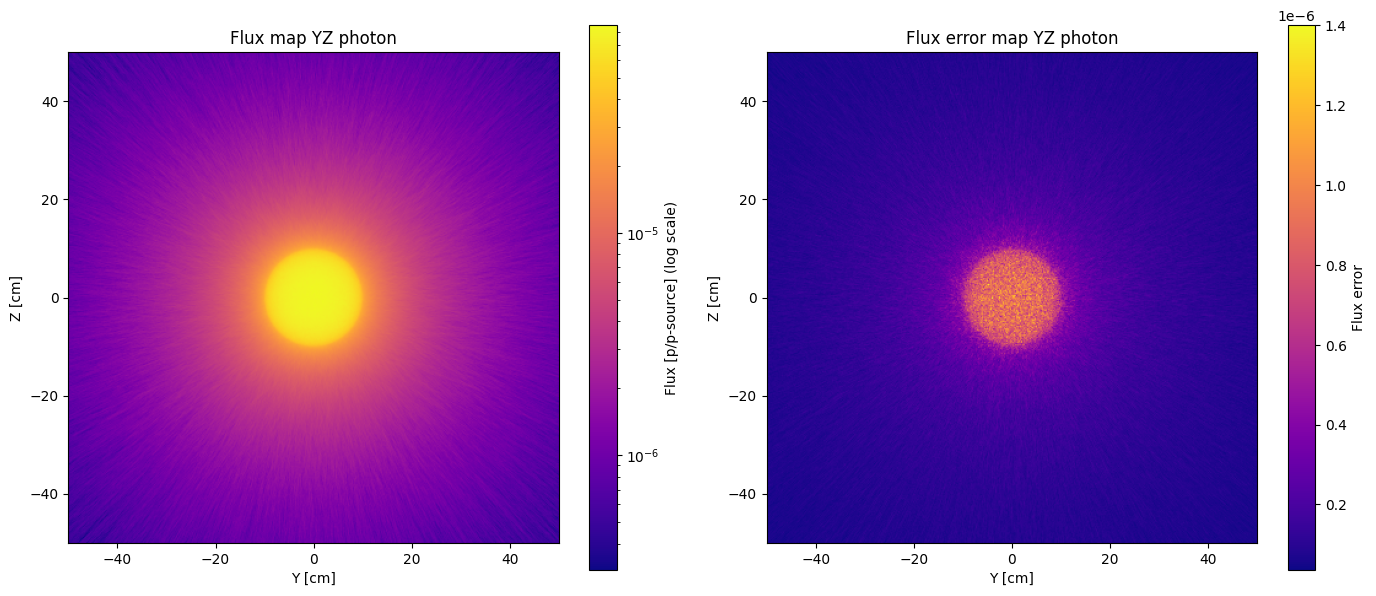

In [34]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_yz", particule_type="photon",
                plane = "yz", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)